In [ ]:
!unrar x /content/Brain_tumour_datasets.rar /content/Brain_tumour_datasets/

Streaming output truncated to the last 5000 lines.
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0099.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0100.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0101.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0102.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0103.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0104.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0105.jpg      24%  OK 
Extracting  /content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0106.jpg      24%  OK 
Extracting  /content/Brain_tumour_dat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [ ]:
ROOT_DIR = "/content/Brain_tumour_datasets/Brain_tumour_datasets"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('glioma', 1621), ('notumor', 2000), ('pituitary', 1757), ('meningioma', 1645)])

# Split the data such that
  * 70 % for the Train Data
  * 15 % for the validation
  * 15 % for the testing

In [ ]:
def data_split(p, split):

  if not os.path.exists("./" + p):
    os.mkdir("./" + p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs(f"./" + p + "/" + dir)
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size = (math.floor(split * number_of_images[dir]) - 5), replace = False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./" + p, dir)
        shutil.copy(O, D)
        os.remove(O)
  else:
    print(f"{p} has already created")

In [ ]:
data_split("train", 0.7)
data_split("val", 0.15)
data_split("test", 0.15)

In [ ]:
from keras.layers import *
from keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
import keras
import tensorflow as tf

In [ ]:
from keras.applications.mobilenet import preprocess_input
import os

def preprocessing_image_train(path):

    if not os.path.exists(path):
        raise ValueError(f"Path {path} does not exist. Please provide a valid directory path.")

    # Data Augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        directory=path,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    return train_generator

# Example usage
path = "/content/train"
try:
    train_data = preprocessing_image_train(path)
except ValueError as e:
    print(e)


Found 4894 images belonging to 4 classes.


In [ ]:
def preprocessing_image(path, augment=False):

    if not os.path.exists(path):
        raise ValueError(f"Path {path} does not exist. Please provide a valid directory path.")

    if augment:
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator = datagen.flow_from_directory(
        directory=path,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    return data_generator

test_path = "/content/test"
val_path = "/content/val"

try:
    test_data = preprocessing_image(test_path)
    val_data = preprocessing_image(val_path)
except ValueError as e:
    print(e)

Found 1032 images belonging to 4 classes.
Found 1032 images belonging to 4 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.applications.mobilenet import MobileNet
import keras

In [ ]:
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Optionally, freeze the base model layers if you are doing transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,652,548 (36.82 MB)

 Trainable params: 6,423,428 (24.50 MB)

 Non-trainable params: 3,229,120 (12.32 MB)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Checkpoint
checkpoint = ModelCheckpoint(
    filepath="bestmodel.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

# Early Stopping
earlystopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='auto'
)

# Combine callbacks into a list
callbacks = [checkpoint, earlystopping]


In [ ]:
# Unfreeze some of the base model layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile with a lower learning rate
from keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler to reduce learning rate when validation accuracy plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)

# Adding lr_scheduler to the callback list
callbacks.append(lr_scheduler)

# Re-train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks,
    verbose=1,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4837 - loss: 1.5636
Epoch 1: val_accuracy improved from -inf to 0.82910, saving model to bestmodel.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 97s 259ms/step - accuracy: 0.4841 - loss: 1.5622 - val_accuracy: 0.8291 - val_loss: 0.5202 - learning_rate: 1.0000e-05
Epoch 2/50
  1/305 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.6875 - loss: 1.1612

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.82910
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6875 - loss: 1.1612 - val_accuracy: 0.7500 - val_loss: 0.6464 - learning_rate: 1.0000e-05
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7738 - loss: 0.6743
Epoch 3: val_accuracy improved from 0.82910 to 0.87500, saving model to bestmodel.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 70s 226ms/step - accuracy: 0.7739 - loss: 0.6742 - val_accuracy: 0.8750 - val_loss: 0.3766 - learning_rate: 1.0000e-05
Epoch 4/50
  1/305 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8125 - loss: 0.6316
Epoch 4: val_accuracy did not improve from 0.87500
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8125 - loss: 0.6316 - val_accuracy: 0.7500 - val_loss: 0.2431 - learning_rate: 1.0000e-05
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7950 - loss: 0.5941
Epoch 5: val_accuracy improved from 0.87500 to 0.89551, saving model to bestmodel.keras
305/305 ━━━━━━━━━━━

In [ ]:
# load the Best Fit Model

from keras.models import load_model

model = load_model("/content/bestmodel.keras")

In [ ]:
acc = model.evaluate(test_data)[1]
print(f"The accuracy of the model is = {acc*100} %")

65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9130 - loss: 0.2099
The accuracy of the model is = 91.27907156944275 %


In [ ]:
h = history.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

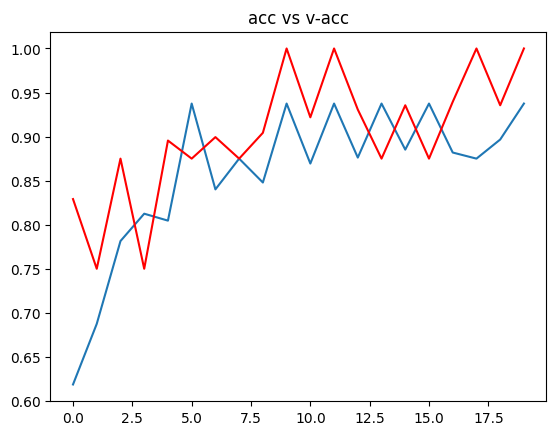

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

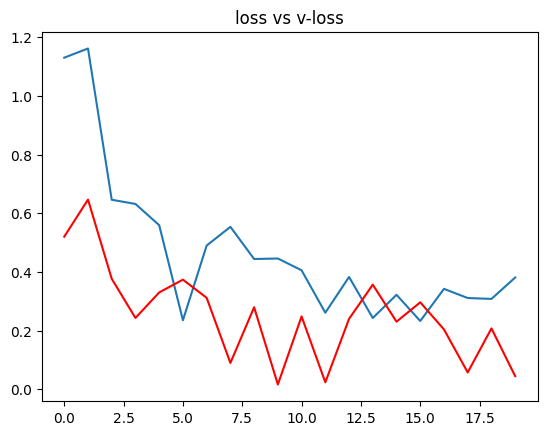

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs v-loss")
plt.show()

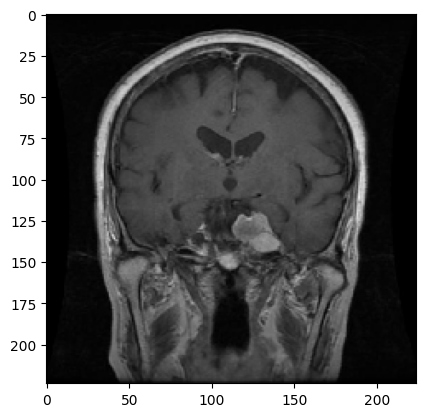

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
meningioma_tumor


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet import preprocess_input
import numpy as np

# Load and preprocess the image
path = "/content/Brain_tumour_datasets/Brain_tumour_datasets/meningioma/Tr-me_0848.jpg"
img = load_img(path, target_size=(224, 224))
x = img_to_array(img)
x = preprocess_input(x)

plt.imshow(img)
plt.show()

# Convert single image to a batch
input_arr = np.expand_dims(x, axis=0)

# Make prediction
pred = np.argmax(model.predict(input_arr))

# Interpret prediction
if pred == 0:
    print("glioma_tumor")
elif pred == 1:
    print("meningioma_tumor")
elif pred == 2:
    print("no_tumor")
else:
    print("pituitary_tumor")